
<a id='lu-tricks'></a>
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Controle Clássico Com Álgebra Linear

## Conteúdo

- [Controle Clássico Com Álgebra Linear](#Controle-Clássico-Com-Álgebra-Linear)  
  - [Resumo](#Resumo)  
  - [Um Problema de Controle](#Um-Problema-de-Controle)  
  - [Teoria do Horizonte Finito](#Teoria-do-Horizonte-Finito)  
  - [O Limite do Horizonte Infinito](#O-Limite-do-Horizonte-Infinito)  
  - [Problemas não Descontados](#Problemas-não-Descontados)  
  - [Implementação](#Implementação)  
  - [Exercícios](#Exercícios)  

> *Devidamente traduzido, revisado e adaptado do [QuantEcon](https://quantecon.org/) pelos bolsistas CNPq, Pedro Luiz H. Furtado e Jonas Aragão M. Corpes, sob supervisão do Prof. Christiano Penna, do CAEN/UFC.*

## Resumo

Em uma aula anterior, [Problemas de Programação Dinâmica Quadrática Linear](https://julia.quantecon.org/../dynamic_programming/lqcontrol.html) estudamos como resolver uma classe especial de otimização dinâmica e problemas de previsão aplicando o método de programação dinâmica. Nesta classe de problemas:

> - a função objetivo é **quadrática** em **estados** e **controles**.  
- a função de transição de uma etapa **linear**.  
- choques são de diferenças Guassianas i.i.d. ou martingale.


Nessa aula e em uma outra complementar [Filtragem Clássica com Álgebra Linear](https://julia.quantecon.org/classical_filtering.html), estudamos a teoria clássica dos problemas de controle ótimo linear-quadrático (QL).

A abordagem clássica não usa os dois métodos intimamente relacionados - programação dinâmica e o Filtro de Kalman - que descrevemos em outras aulas, nomeadas de [Problemas de Programação Dinâmica Quadrática Linear](https://julia.quantecon.org/../dynamic_programming/lqcontrol.html) e [Um Primeiro Olhar sobre o Filtro de Kalman](https://julia.quantecon.org/../tools_and_techniques/kalman.html).

Em vez disso, eles usam:

> - métodos de transformação $ z $ e operador defasagem, ou.  
- decomposições matriciais aplicadas a sistemas lineares de condições de primeira ordem para problemas ótimos. 



Nessa aula e na seguinte [Filtragem Clássica com Álgebra Linear](https://julia.quantecon.org/classical_filtering.html), contamos principalmente com álgebra linear elementar.

A principal ferramenta da álgebra linear que colocaremos aqui é a [Decomposição LU](https://en.wikipedia.org/wiki/LU_decomposition).

Começaremos com problemas de horizonte discreto.

Então veremos os problemas de horizonte infinito como limites apropriados desses problemas de horizonte finito.

Posteriormente, examinaremos a estreita conexão entre o controle QL e a previsão de mínimos quadrados e os problemas de filtragem.

Essas classes de problemas estão conectadas no sentido de que para resolver cada uma, essencialmente é usada a mesma matemática.

### Referências

Referências usuais incluem [[Whi63]](https://julia.quantecon.org/../zreferences.html#whittle1963), [[HS80]](https://julia.quantecon.org/../zreferences.html#hansar1980), [[Orf88]](https://julia.quantecon.org/../zreferences.html#orfanidisoptimum1988), [[AP91]](https://julia.quantecon.org/../zreferences.html#athanasios1991), e [[Mut60]](https://julia.quantecon.org/../zreferences.html#muth1960).

### Configuração

In [1]:
using InstantiateFromURL
github_project("QuantEcon/quantecon-notebooks-julia", version = "0.5.0")
# github_project("QuantEcon/quantecon-notebooks-julia", version = "0.5.0", instantiate = true) # uncomment to force package installation

In [2]:
using Polynomials, Plots, Random, Parameters
using LinearAlgebra, Statistics

## Um Problema de Controle

Seja $ L $ o **operador defasagem**, então, para a sequência $ \{x_t\} $ temos $ L x_t = x_{t-1} $.

De modo mais geral, seja $ L^k x_t = x_{t-k} $ com $ L^0 x_t = x_t $ e

$$
d(L) = d_0 + d_1 L+ \ldots + d_m L^m
$$

onde $ d_0, d_1, \ldots, d_m $ é uma determinada sequência escalar.

Considere o problema de controle de tempo discreto:


<a id='equation-oneone'></a>
$$
\max_{\{y_t\}}
\lim_{N \to \infty} \sum^N_{t=0} \beta^t\,
\left\{
     a_t y_t - {1 \over 2}\, hy^2_t - {1 \over 2} \,
         \left[ d(L)y_t \right]^2
\right\}, \tag{1}
$$

onde

- $ h $ é um parâmetro positivo e $ \beta \in (0,1) $ é um fator de desconto.  
- $ \{a_t\}_{t \geq 0} $ é uma sequência de ordem exponencial inferior a $ \beta^{-1/2} $, cujo entendemos ser $ \lim_{t \rightarrow \infty} \beta^{\frac{t}{2}} a_t = 0 $  


A maximização em [(1)](#equation-oneone) está sujeita as condições iniciais $ y_{-1}, y_{-2} \ldots, y_{-m} $.

A maximização está sobre sequências infinitas $ \{y_t\}_{t \geq 0} $.

### Exemplo 

A formulação do problema QL dada acima é ampla o suficiente para abranger muitos modelos úteis.

Como uma ilustração simples, lembre-se de que no [lqcontrol](https://julia.quantecon.org/../dynamic_programming/lqcontrol.html) consideramos um monopolista que enfrenta choques estocásticos de demanda e custos de ajuste.

Vamos considerar uma versão determinística desse problema, em que o monopolista maximiza a soma descontada:

$$
\sum_{t=0}^{\infty} \beta^t \pi_t
$$

e

$$
\pi_t = p_t q_t - c q_t - \gamma (q_{t+1} - q_t)^2
\quad \text{com} \quad
p_t = \alpha_0 - \alpha_1 q_t + d_t
$$

Nessa expressão, $ q_t $ é a quantidade, $ c $ é o custo médio de produção, e $ d_t $ é um choque de demanda.

O termo $ \gamma (q_{t+1} - q_t)^2 $ representa os custos de ajustamento.

Você poderá confirmar que a função objetivo pode ser reescrita como [(1)](#equation-oneone) quando:

- $ a_t := \alpha_0 + d_t - c $  
- $ h := 2 \alpha_1 $  
- $ d(L) := \sqrt{2 \gamma}(I - L) $  


Exemplos adicionais deste problema para demanda de fatores, crescimento econômico e problemas de políticas governamentais são apresentados no cap. IX de [[Sar87]](https://julia.quantecon.org/../zreferences.html#sargent1987).

## Teoria do Horizonte Finito

Primeiro estudamos uma versão finita $ N $ do problema.

Mais tarde estudaremos uma solução de problema de horizonte infinito como uma versão limitadora de um problema de horizonte finito.

(Isso exigirá cuidado, pois os limites como  $ N \to \infty $ das condições necessárias e suficientes para maximizar os resultados de versões finitas $ N $ de [(1)](#equation-oneone)
não são suficientes para maximizar [(1)](#equation-oneone))

Começamos por:

1. fixando $ N > m $,  
1. diferenciando a versão finita de [(1)](#equation-oneone) com respeito a $ y_0, y_1, \ldots, y_N $, e 
1. definir essas derivadas a zero


Para $ t=0, \ldots, N-m $ essas condições de primeira ordem necessárias são as
*equações de Euler*.

Para $ t = N-m + 1, \ldots, N $, as condições de primeira ordem são um conjunto de
*condições terminais*.

Considere o termo:

$$
\begin{aligned}
J
& = \sum^N_{t=0} \beta^t [d(L) y_t] [d(L) y_t]
\\
& = \sum^N_{t=0}
    \beta^t \, (d_0 \, y_t + d_1 \, y_{t-1} + \cdots + d_m \, y_{t-m}) \,
               (d_0 \, y_t + d_1 \, y_{t-1} + \cdots  + d_m\, y_{t-m})
\end{aligned}
$$

Diferenciando $ J $ com respeito a $ y_t $ para
$ t=0,\ 1,\ \ldots,\ N-m $ temos:

$$
\begin{aligned}
{\partial {J} \over \partial y_t}
   & = 2 \beta^t \, d_0 \, d(L)y_t +
       2 \beta^{t+1} \, d_1\, d(L)y_{t+1} + \cdots +
       2 \beta^{t+m}\, d_m\, d(L) y_{t+m} \\
   & = 2\beta^t\, \bigl(d_0 + d_1 \, \beta L^{-1} + d_2 \, \beta^2\, L^{-2} +
       \cdots + d_m \, \beta^m \, L^{-m}\bigr)\, d (L) y_t\
\end{aligned}
$$

Podemos escrever isso de forma mais sucinta como:


<a id='equation-onetwo'></a>
$$
{\partial {J} \over \partial y_t}
    = 2 \beta^t \, d(\beta L^{-1}) \, d (L) y_t \tag{2}
$$

Diferenciando $ J $ com respeito a $ y_t $ para $ t = N-m + 1, \ldots, N $ temos:


<a id='equation-onethree'></a>
$$
\begin{aligned}
 {\partial J \over \partial y_N}
 &= 2 \beta^N\, d_0 \, d(L) y_N \cr
   {\partial J \over \partial y_{N-1}}
 &= 2\beta^{N-1} \,\bigl[d_0 + \beta \,
   d_1\, L^{-1}\bigr] \, d(L)y_{N-1} \cr
   \vdots
 & \quad \quad \vdots \cr
   {\partial {J} \over \partial y_{N-m+1}}
 &= 2 \beta^{N-m+1}\,\bigl[d_0 + \beta
   L^{-1} \,d_1 + \cdots + \beta^{m-1}\, L^{-m+1}\, d_{m-1}\bigr]  d(L)y_{N-m+1}
\end{aligned} \tag{3}
$$

Com essas preliminares, estamos preparados para diferenciar [(1)](#equation-oneone).

Diferenciando [(1)](#equation-oneone) com respeito a $ y_t $ para $ t=0, \ldots, N-m $ temos as equação de Euler.


<a id='equation-onefour'></a>
$$
\bigl[h+d\,(\beta L^{-1})\,d(L)\bigr] y_t = a_t,
\quad t=0,\, 1,\, \ldots, N-m \tag{4}
$$

O sistema de equações [(4)](#equation-onefour) formam uma *equação da diferença*  $ 2 \times m $ de ordem linear que deve valer para os valores de $ t $ indicados.

Diferenciando [(1)](#equation-oneone) com respeito a $ y_t $ para $ t = N-m + 1, \ldots, N $ temos as condições terminais.


<a id='equation-onefive'></a>
$$
\begin{aligned}
\beta^N  (a_N - hy_N - d_0\,d(L)y_N)
&= 0  \cr
  \beta^{N-1} \left(a_{N-1}-hy_{N-1}-\Bigl(d_0 + \beta \, d_1\,
L^{-1}\Bigr)\, d(L)\, y_{N-1}\right)
& = 0 \cr
 \vdots & \vdots\cr
\beta^{N-m+1} \biggl(a_{N-m+1} - h y_{N-m+1} -(d_0+\beta L^{-1}
d_1+\cdots\  +\beta^{m-1} L^{-m+1} d_{m-1}) d(L) y_{N-m+1}\biggr)
& = 0
\end{aligned} \tag{5}
$$

No problema finito $ N $, queremos simultâneamente resolver [(4)](#equation-onefour) sujeito a $ m $ condições iniciais
$ y_{-1}, \ldots, y_{-m} $ e $ m $ condições terminais
[(5)](#equation-onefive).

Essas condições definem com exclusividade a solução do problema finito de $ N $.

Ou seja, para o problma finito $ N $,
as condições [(4)](#equation-onefour) e [(5)](#equation-onefive) são necessários e suficientes para um máximo,
pela concavidade da função objetivo.

A seguir, descrevemos como obter a solução usando métodos de matriz.

<a id='fdlq'></a>

### Métodos de Matriz

Vamos ver como a álgebra linear pode ser usada para enfrentar e lançar luz sobre o problema de controle de QL do horizonte finito.

#### Um único termo de defasagem

Vamos começar com o caso especial em que $ m=1 $.

Queremos resolver o sistema de $ N+1 $ equações lineares:

<a id='equation-oneff'></a>
$$
\begin{aligned}
\bigl[h & + d\, (\beta L^{-1})\, d\, (L) ] y_t = a_t, \quad
t = 0,\ 1,\ \ldots,\, N-1\cr
\beta^N & \bigl[a_N-h\, y_N-d_0\, d\, (L) y_N\bigr] = 0
\end{aligned} \tag{6}
$$

onde $ d(L) = d_0 + d_1 L $.

Essas equações devem ser resolvidas para
$ y_0, y_1, \ldots, y_N $ como funções de
$ a_0, a_1, \ldots,  a_N $ e $ y_{-1} $.

Seja

$$
\phi (L)
= \phi_0 + \phi_1 L + \beta \phi_1 L^{-1}
= h + d (\beta L^{-1}) d(L)
= (h + d_0^2 + d_1^2) + d_1 d_0 L+ d_1 d_0 \beta L^{-1}
$$

Então podemos representar [(6)](#equation-oneff) como a equação da matriz:


<a id='equation-onefourfive'></a>
$$
\left[
    \begin{matrix}
        (\phi_0-d_1^2) & \phi_1 & 0 & 0 & \ldots & \ldots & 0 \cr
        \beta \phi_1 & \phi_0 & \phi_1 & 0 & \ldots & \dots & 0 \cr
        0 & \beta \phi_1 & \phi_0 & \phi_1 & \ldots & \ldots & 0 \cr
        \vdots &\vdots & \vdots & \ddots & \vdots & \vdots & \vdots \cr
        0 & \ldots & \ldots & \ldots & \beta \phi_1 & \phi_0 &\phi_1 \cr
        0 & \ldots & \ldots & \ldots & 0 & \beta \phi_1 & \phi_0
    \end{matrix}
\right]
\left [
    \begin{matrix}
        y_N \cr y_{N-1} \cr y_{N-2} \cr \vdots \cr
        y_1 \cr y_0
    \end{matrix}
\right ] =
\left[
\begin{matrix}
    a_N \cr a_{N-1} \cr a_{N-2} \cr \vdots \cr a_1 \cr
    a_0 - \phi_1 y_{-1}
\end{matrix}
\right] \tag{7}
$$

or


<a id='equation-onefoursix'></a>
$$
W\bar y = \bar a \tag{8}
$$

Observe como escolhemos organizar o $ y_t $ na ordem reversa do tempo.

A matriz $ W $ do lado esquerdo de [(7)](#equation-onefourfive) é “quase” uma
[matriz de Toeplitz](https://en.wikipedia.org/wiki/Toeplitz_matrix) (onde cada
diagonal descendente é constante)

Existem duas fontes de desvio de forma de uma matriz de Toeplitz:

1. O primeiro elemento difere dos demais elementos diagonais, refletindo a condição do terminal.
1. Os elementos subdiagonais são iguais a $ \beta $ vezes os elementos da superdiagonal.  


A solução de [(8)](#equation-onefoursix) pode ser expressada na forma:


<a id='equation-onefourseven'></a>
$$
\bar y = W^{-1} \bar a \tag{9}
$$

que representa cada elemento $ y_t $ de $ \bar y $ em função de todo o vetor $ \bar a $.

Que é, $ y_t $ é uma função dos valores passados, presentes e futuros de $ a $, bem como da condição inicial $ y_{-1} $.

#### Uma representação alternativa

Uma maneira alternativa de expressar a solução para [(7)](#equation-onefourfive) ou
[(8)](#equation-onefoursix) está na forma chamada **feedback-feedforward**.

A ideia aqui é encontrar uma solução expressando $ y_t $ como uma função do $ y $ *passado* e *atual* e *futuro* $ a $.

Para alcançar essa solução, pode se usar uma [decomposição LU](https://en.wikipedia.org/wiki/LU_decomposition) de $ W $.

Sempre existe uma decomposição $ W $ da forma $ W= LU $
onde

- $ L $ é uma matriz retangular inferior $ (N+1) \times (N+1) $  
- $ U $ é uma matriz retangular superior $ (N+1) \times (N+1) $.  


A fatoração pode ser normalizada para que os elementos diagonais de $ U $ sejam unidades.

Usando a representação LU em [(9)](#equation-onefourseven), obtemos:


<a id='equation-onefournine'></a>
$$
U \bar y = L^{-1} \bar a \tag{10}
$$

Sabendo que $ L^{-1} $ é rentangular inferior, essa representação expressa
$ y_t $ como uma função de:

-  $ y $ defasado (via o termo $ U \bar y $), e  
-  $ a $’s presente e futuro (via o termo $ L^{-1} \bar a $)  


Porque existem zeros em toda parte na matriz
na esquerda de [(7)](#equation-onefourfive) exceto na diagonal, superdiagonal, e
subdiagonal, a decomposição $ LU $ toma:

- $ L $ a ser zero, exceto na diagonal e na subdiagonal principal.
- $ U $ a ser zero, exceto na diagonal e na subdiagonal principal.


então, [(10)](#equation-onefournine) tem a forma:

$$
\left[
\begin{matrix}
    1& U_{12} & 0 & 0 & \ldots & 0 & 0 \cr
    0 & 1 & U_{23} & 0 & \ldots & 0 & 0 \cr
    0 & 0 & 1 & U_{34} & \ldots & 0 & 0 \cr
    0 & 0 & 0 & 1 & \ldots & 0 & 0\cr
    \vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots\cr
    0 & 0 & 0 & 0 & \ldots & 1 & U_{N,N+1} \cr
    0 & 0 & 0 & 0 & \ldots & 0 & 1
\end{matrix}
\right] \ \ \
\left[
\begin{matrix}
    y_N \cr y_{N-1} \cr y_{N-2} \cr y_{N-3} \cr \vdots \cr y_1 \cr y_0
\end{matrix}
\right] =
$$

$$
\quad
\left[
\begin{matrix}
    L^{-1}_{11} & 0 & 0 & \ldots & 0 \cr
    L^{-1}_{21} & L^{-1}_{22} & 0 & \ldots & 0 \cr
    L^{-1}_{31} & L^{-1}_{32} & L^{-1}_{33}& \ldots & 0 \cr
    \vdots & \vdots & \vdots & \ddots & \vdots\cr
    L^{-1}_{N,1} & L^{-1}_{N,2} & L^{-1}_{N,3} & \ldots & 0 \cr
    L^{-1}_{N+1,1} & L^{-1}_{N+1,2} & L^{-1}_{N+1,3} & \ldots &
    L^{-1}_{N+1\, N+1}
\end{matrix}
\right]
\left[
\begin{matrix}
    a_N \cr a_{N-1} \cr a_{N-2} \cr \vdots \cr a_1 \cr a_0 -
    \phi_1 y_{-1}
\end{matrix}
\right ]
$$

onde $ L^{-1}_{ij} $ é o elemento $ (i,j) $ de $ L^{-1} $ e $ U_{ij} $ é o elemento $ (i,j) $ de $ U $.

Observe como o lado esquerdo de um determinado $ t $ envolve $ y_t $ e um valor defasado $ y_ {t-1} $ enquanto o lado direito envolve todos os valores futuros do processo de forçamento $ a_t, a_ {t + 1}, \ldots, a_N $.

#### Termos adicionais de defasagens

Indicamos brevemente como essa abordagem se estende ao problema de
$ m > 1 $.

Suponha que $ \beta = 1 $ e seja $ D_{m+1} $ a matriz simétrica cujos elementos são determinados pela seguinte fórmula
$ (m+1) \times (m+1) $ cujos elementos são determinados pela seguinte fórmula:

$$
D_{jk} = d_0 d_{k-j} + d_1 d_{k-j+1} + \ldots + d_{j-1} d_{k-1}, \qquad k
\geq j
$$

Seja $ I_{m+1} $ a matriz identidade $ (m+1) \times (m+1) $.

Seja $ \phi_j $ os coeficiêntes na expansão $ \phi (L) = h + d (L^{-1}) d (L) $.

Então as condições de primeiroa ordem [(4)](#equation-onefour) e [(5)](#equation-onefive) podem ser expressas como:

$$
(D_{m+1} + hI_{m+1})\ \
\left[
\begin{matrix}
    y_N \cr y_{N-1} \cr \vdots \cr y_{N-m}
\end{matrix}
\right]\
= \ \left[
\begin{matrix}
     a_N \cr a_{N-1} \cr \vdots \cr a_{N-m}
 \end{matrix}
\right] + M\
\left[
    \begin{matrix}
        y_{N-m+1}\cr y_{N-m-2}\cr \vdots\cr y_{N-2m}
    \end{matrix}
\right]
$$

onde $ M $ é $ (m+1)\times m $ e

$$
M_{ij} = \begin{cases}
D_{i-j,\,m+1} \textrm{ para } i>j  \\
 0  \textrm{ for }  i\leq j\end{cases}
$$

$$
\begin{aligned}
\phi_m y_{N-1} &+ \phi_{m-1} y_{N-2} + \ldots + \phi_0 y_{N-m-1} +
\phi_1 y_{N-m-2} +\cr
&\hskip.75in \ldots + \phi_m y_{N-2m-1} = a_{N-m-1} \cr
\phi_m y_{N-2} &+ \phi_{m-1} y_{N-3} + \ldots + \phi_0 y_{N-m-2} + \phi_1
y_{N-m-3} +\cr
&\hskip.75in \ldots + \phi_m y_{N-2m-2} = a_{N-m-2} \cr
&\qquad \vdots \cr
\phi_m y_{m+1} &+ \phi_{m-1} y_m + + \ldots + \phi_0 y_1 + \phi_1 y_0 +
\phi_m y_{-m+1} = a_1 \cr
\phi_m y_m + \phi_{m-1}& y_{m-1} + \phi_{m-2} + \ldots + \phi_0 y_0 + \phi_1
y_{-1} + \ldots + \phi_m y_{-m} = a_0
\end{aligned}
$$

Como antes, podemos expressar essa equação como $ W \bar y = \bar a $.

A matriz na esquerda dessa equação é “quase” do tipo de Toeplitz, a principal exceção sendo a sub-matriz $ m \times m $ na parte superior canto esquerdo.

Podemos representar essa solução na forma feedback-feedforward obtendo uma decomposição $ LU = W $, e obtenha:


<a id='equation-onefivetwo'></a>
$$
U \bar y = L^{-1} \bar a \tag{11}
$$

$$
\begin{aligned} \sum^t_{j=0}\, U_{-t+N+1,\,-t+N+j+1}\,y_{t-j} &= \sum^{N-t}_{j=0}\,
L_{-t+N+1,\, -t+N+1-j}\, \bar a_{t+j}\ ,\cr
&\qquad t=0,1,\ldots, N
\end{aligned}
$$

onde $ L^{-1}_{t,s} $ é o elemento na posição $ (t,s) $ de $ L $, e similarmente para $ U $.

O lado esquerdo da equação [(11)](#equation-onefivetwo) é a parte de “feedback” da lei de controle ótimo para $ y_t $, enquanto o lado direito da equação é a parte “feedforward”.

Observamos que existe uma lei de controle diferente para cada $ t $.

Assim, no caso do horizonte finito, a lei de controle ideal depende do tempo.

É natural suspeitar que, como $ N \rightarrow\infty $, [(11)](#equation-onefivetwo)
torna-se equivalente à solução do nosso problema de horizonte infinito,
que abaixo mostraremos pode ser expresso como:

$$
c(L) y_t = c (\beta L^{-1})^{-1} a_t\ ,
$$

para que como $ N \rightarrow \infty $ esperamos que para cada fixo
$ t, U^{-1}_{t, t-j}
\rightarrow c_j $ e $ L_{t,t+j} $ aborda o coeficiente de
$ L^{-j} $ na expansão de $ c(\beta L^{-1})^{-1} $.

Essa suspeita é verdadeira sob condições gerais que estudaremos mais adiante.

Por enquanto, observamos que, ao criar a matriz $ W $ para grandes
$ N $ e fatorando-o na forma $ LU $, boas aproximações
para $ c (L) $ e $ c (\beta L ^{- 1}) ^{- 1} $ podem ser obtidos.

## O Limite do Horizonte Infinito

Para o problema do horizonte infinito, propomos descobrir as condições de primeira ordem necessárias, tomando os limites de [(4)](#equation-onefour) e [(5)](#equation-onefive) como
$ N \to \infty $.

Essa abordagem é valida, e os limites de [(4)](#equation-onefour) e [(5)](#equation-onefive) como $ N $ abordagens ao infinito são condições necessárias de primeira ordem para um máximo.

No entanto, para o problema de horizonte infinito $ \beta < 1 $, os limites de [(4)](#equation-onefour) e [(5)](#equation-onefive) são, em geral, não suficientes para o máximo.

Que são, os limites de [(5)](#equation-onefive) que não forneçe informações suficientes exclusivamente para determinar a solução da equação de Euler [(4)](#equation-onefour) que maximiza [(1)](#equation-oneone).

Como veremos abaixo, uma condição secundária no caminho de $ y_t $ que, juntamente com [(4)](#equation-onefour) é suficiente para obter um ótimo.

<a id='equation-onesix'></a>
$$
\sum^\infty_{t=0}\ \beta^t\, hy^2_t < \infty \tag{12}
$$

Todos os caminhos que satisfazem as equações de Euler, exceto o que devemos
selecione abaixo, violam essa condição e, portanto, evidentemente levam a
(muitos) valores mais baixos de [(1)](#equation-oneone) do que o
caminho ideal selecionado pelo procedimento de solução abaixo.

Considere a *equação característica* associada à equação de Euler:

<a id='equation-oneseven'></a>
$$
h+d \, (\beta z^{-1})\, d \, (z) = 0 \tag{13}
$$

Perceba que se $ \tilde z $ é uma raiz da equação [(13)](#equation-oneseven), então é $ \beta \tilde z^{-1} $.

Logo, as raizes de [(13)](#equation-oneseven) vêm em “$ \beta $” pares recíprocos.

Suponha que as raizes de [(13)](#equation-oneseven) seja distintas.

Sejam as raízes, em ordem decrescente de acordo com seus módulos, $ z_1, z_2, \ldots, z_{2m} $.

Da propriedade de pares recíprocos e do pressuposto de raizes distintas, segue-se que $ \vert z_j \vert > \sqrt \beta\ \hbox{ para } j\leq m \hbox
{ e } \vert z_j \vert < \sqrt\beta\ \hbox { para } j > m $.

Também segue que $ z_{2m-j} = \beta z^{-1}_{j+1}, j=0, 1, \ldots, m-1 $.

Portanto, o polinômio característico no lado esquerdo de [(13)](#equation-oneseven) pode ser expresso como:


<a id='equation-oneeight'></a>
$$
\begin{aligned}
h+d(\beta z^{-1})d(z)
&= z^{-m} z_0(z-z_1)\cdots
(z-z_m)(z-z_{m+1}) \cdots (z-z_{2m}) \cr
&= z^{-m} z_0 (z-z_1)(z-z_2)\cdots (z-z_m)(z-\beta z_m^{-1})
\cdots  (z-\beta z^{-1}_2)(z-\beta z_1^{-1})
\end{aligned} \tag{14}
$$

onde $ z_0 $ é uma constante.

Em [(14)](#equation-oneeight), substituimos $ (z-z_j) = -z_j (1- {1 \over z_j}z) $ e
$ (z-\beta z_j^{-1}) = z(1 - {\beta \over z_j} z^{-1}) $ para $ j = 1, \ldots, m $ para obter:

$$
h+d(\beta z^{-1})d(z)
= (-1)^m(z_0z_1\cdots z_m)
(1- {1\over z_1} z) \cdots (1-{1\over z_m} z)(1- {1\over z_1} \beta z^{-1})
\cdots(1-{1\over z_m} \beta z^{-1})
$$

Agora definimos $ c(z) = \sum^m_{j=0} c_j \, z^j $ como:


<a id='equation-onenine'></a>
$$
c\,(z)=\Bigl[(-1)^m z_0\, z_1 \cdots z_m\Bigr]^{1/2} (1-{z\over z_1}) \,
(1-{z\over z_2}) \cdots (1- {z\over z_m}) \tag{15}
$$

Perceba que [(14)](#equation-oneeight) pode ser escrito:


<a id='equation-oneten'></a>
$$
h + d \ (\beta z^{-1})\ d\ (z) = c\,(\beta z^{-1})\,c\,(z) \tag{16}
$$

é útil escrever [(15)](#equation-onenine) como:


<a id='equation-oneeleven'></a>
$$
c(z) = c_0(1-\lambda_1\, z) \ldots (1-\lambda_m z) \tag{17}
$$

onde

$$
c_0
= \left[(-1)^m\, z_0\, z_1 \cdots z_m\right]^{1/2};
\quad \lambda_j={1 \over z_j},\,\  j=1, \ldots, m
$$

Sabendo que $ \vert z_j \vert > \sqrt \beta \hbox { para } j = 1, \ldots, m $ segue-se que $ \vert \lambda_j \vert < 1/\sqrt \beta $ para $ j = 1,
\ldots, m $.

Usando [(17)](#equation-oneeleven), podemos expressar a fatoração [(16)](#equation-oneten) como:

$$
h+d (\beta z^{-1})d(z) = c^2_0 (1-\lambda_1 z) \cdots
(1 - \lambda_m z) (1-\lambda_1 \beta z^{-1})
\cdots (1 - \lambda_m \beta z^{-1})
$$

Em suma, construímos uma fatoração [(16)](#equation-oneten) do polinômio característico para a equação de Euler na qual os zeros de $ c (z) $
exceder $ \beta ^ {1/2} $ no módulo e os zeros de
$ c \, (\beta z ^{- 1}) $ é menor que $ \beta ^{1/2} $ no módulo.

Usando [(16)](#equation-oneten), agora podemos escrever a equação de Euler como:

$$
c(\beta L^{-1})\,c\,(L)\, y_t = a_t
$$

A única solução da equação de Euler que satisfaz a condição [(12)](#equation-onesix)
é:


<a id='equation-onethirteen'></a>
$$
c(L)\,y_t = c\,(\beta L^{-1})^{-1}a_t \tag{18}
$$

Isso pode ser estabelecido usando um argumento paralelo que está no
capítulo IX de [[Sar87]](https://julia.quantecon.org/../zreferences.html#sargent1987).

Para exibir a solução em um formulário
paralelo ao de [[Sar87]](https://julia.quantecon.org/../zreferences.html#sargent1987), usamos [(17)](#equation-oneeleven) para escrever
[(18)](#equation-onethirteen) como:


<a id='equation-junk'></a>
$$
(1-\lambda_1 L) \cdots (1 - \lambda_mL)y_t = {c^{-2}_0 a_t \over (1-\beta \lambda_1 L^{-1}) \cdots (1 - \beta \lambda_m L^{-1})} \tag{19}
$$

Usando [Frações Parciais](https://en.wikipedia.org/wiki/Partial_fraction_decomposition), podemos escrever o polinômio característico em o lado direito de [(19)](#equation-junk) como:

$$
\sum^m_{j=1} {A_j \over 1 - \lambda_j \, \beta L^{-1}}
 \quad \text{onde} \quad
A_j := {c^{-2}_0 \over \prod_{i \not= j}(1-{\lambda_i \over \lambda_j})}
$$

Então [(19)](#equation-junk) pode ser escrito:

$$
(1-\lambda_1 L) \cdots (1-\lambda_m L) y_t = \sum^m_{j=1} \, {A_j \over 1 -
\lambda_j \, \beta L^{-1}} a_t
$$

ou


<a id='equation-onefifteen'></a>
$$
(1 - \lambda_1 L) \cdots (1 - \lambda_m L) y_t = \sum^m_{j=1}\, A_j
\sum^\infty_{k=0}\, (\lambda_j\beta)^k\, a_{t+k} \tag{20}
$$

A equação [(20)](#equation-onefifteen) expressa a sequência ótima para $ y_t $ em termos de $ m $ $ y $ defasados, e $ m $ somas geométricas infinitas ponderadas de futuros $ a_t $.

Além disso, [(20)](#equation-onefifteen) é a única solução para a equação de Euler que satisfaz as condições iniciais e a condição [(12)](#equation-onesix).

Com efeito, a condição [(12)](#equation-onesix) nos obriga a
resolver as raízes "instáveis" de $ h+d (\beta z^{-1})d(z) $ a frente
(consulte [[Sar87]](https://julia.quantecon.org/../zreferences.html#sargent1987)).

A etapa de fatorar o polinômio $ h+d (\beta z^{-1})\, d(z) $ para
$ c\, (\beta z^{-1})c\,(z) $, onde os zeros de $ c\,(z) $ todos
tem módulo superior a $ \sqrt\beta $, é fundamental para resolver o problema.

Observamos dois recursos da solução [(20)](#equation-onefifteen):

- Se $ \vert \lambda_j \vert < 1/\sqrt \beta $ para todo $ j $, segue que $ (\lambda_j \ \beta) < \sqrt \beta $.  
- A suposição de que $ \{ a_t \} $ é de ordem exponencial menor que $ 1 /\sqrt \beta $ é suficiente para garantir que as somas geométricas dos futuros $ a_t $ no lado direito de [(20)](#equation-onefifteen) converge.  


Vimos imediatamente que essas somas convergem sob a condição mais fraca que $ \{ a_t\} $ é de
ordem exponencial menor que $ \phi^{-1} $ onde
$ \phi = \max \, \{\beta \lambda_i, i=1,\ldots,m\} $.

Perceba que com $ a_t $ identicamente zero, [(20)](#equation-onefifteen) implica que em geral $ \vert y_t \vert $ eventualmente cresce exponencialmente a um
taxa dada por $ \max_i \vert \lambda_i \vert $.

A condição
$ \max_i \vert \lambda_i \vert <1 /\sqrt \beta $ garante que a condição [(12)](#equation-onesix) é satisfeita.

De fato, $ \max_i \vert \lambda_i
\vert < 1 /\sqrt \beta $ é uma condição necessária para [(12)](#equation-onesix) se manter.

Se [(12)](#equation-onesix) não fosse satisfeito, a função objetivo iria divergir para $ - \infty $, implicando que o caminho $ y_t $ não poderia ser o ideal.

Por exemplo, com $ a_t = 0 $, para todo $ t $, é fácil descrever uma política ingênua (não ótima) para $ \{y_t, t\geq 0\} $ que fornece um valor finito de [(17)](#equation-oneeleven).

Nós podemos simplesmente fazer $ y_t = 0 \hbox { for } t\geq 0 $.

Esta política envolve no máximo $ m $ valores diferentes de zero de
$ hy^2_t $ e $ [d(L)y_t]^2 $, e assim produz um valor finito de
[(1)](#equation-oneone).

Portanto, é fácil dominar um caminho que viola [(12)](#equation-onesix).

## Problemas não Descontados

Vale a pena focar em um caso especial dos problemas QL acima:
o problema não descontado que surge quando $ \beta = 1 $.

Nesse caso, a equação de Euler é:

$$
\Bigl( h + d(L^{-1})d(L) \Bigr)\, y_t = a_t
$$

A fatoração do polinômio caracteristico [(16)](#equation-oneten) se torna:

$$
\Bigl(h+d \, (z^{-1})d(z)\Bigr) = c\,(z^{-1})\, c\,(z)
$$

onde

$$
\begin{aligned}
c\,(z) &= c_0 (1 - \lambda_1 z) \ldots (1 - \lambda_m z) \cr
c_0 &= \Bigl[(-1)^m z_0 z_1 \ldots z_m\Bigr ] \cr
\vert \lambda_j \vert &< 1 \, \hbox { para } \, j = 1, \ldots, m\cr
\lambda_j &= \frac{1}{z_j} \hbox{ para } j=1,\ldots, m\cr
z_0 &= \hbox{ constante}
\end{aligned}
$$

A solução do problema se torna:

$$
(1 - \lambda_1 L) \cdots (1 - \lambda_m L) y_t = \sum^m_{j=1} A_j
\sum^\infty_{k=0} \lambda^k_j a_{t+k}
$$

### Transformação  do problema descontado para  não descontado.

Problemas descontados sempre podem ser convertido em problemas não descontados por meio de uma transformação simples.

Considere o problema [(1)](#equation-oneone) com $ 0 < \beta < 1 $.

Defina as variáveis transformadas:

<a id='equation-onetwenty'></a>
$$
\tilde a_t = \beta^{t/2} a_t,\ \tilde y_t = \beta^{t/2} y_t \tag{21}
$$

Então perceba que $ \beta^t\,[d\, (L) y_t ]^2=[\tilde d\,(L)\tilde y_t]^2 $ com
$ \tilde d \,(L)=\sum^m_{j=0} \tilde d_j\, L^j $ e $ \tilde d_j = \beta^{j/2}
d_j $.

Então a função de critério original [(1)](#equation-oneone) é equivalente a:


<a id='equation-oneoneprime'></a>
$$
\lim_{N \rightarrow \infty}
\sum^N_{t=0}
\{\tilde a_t\, \tilde y_t - {1 \over 2} h\,\tilde y^2_t - {1\over 2}
[ \tilde d\,(L)\, \tilde y_t]^2 \} \tag{22}
$$

que deve ser maximizado sobre sequências $ \{\tilde y_t,\  t=0, \ldots\} $ sujeito a
$ \tilde y_{-1}, \cdots, \tilde y_{-m} $ dado e $ \{\tilde a_t,\  t=1, \ldots\} $ uma sequência limitada conhecida.

A equação de Euler para esse problema é $ [h+\tilde d \,(L^{-1}) \, \tilde d\, (L) ]\, \tilde y_t = \tilde a_t $.

A solução é:

$$
(1 - \tilde \lambda_1 L) \cdots (1 - \tilde \lambda_m L)\,\tilde y_t =
\sum^m_{j=1} \tilde A_j \sum^\infty_{k=0} \tilde \lambda^k_j \, \tilde a_{t+k}
$$

ou


<a id='equation-onetwentyone'></a>
$$
\tilde y_t = \tilde f_1 \, \tilde y_{t-1} + \cdots + \tilde f_m\,
\tilde y_{t-m} + \sum^m_{j=1} \tilde A_j \sum^\infty_{k=0} \tilde \lambda^k_j
\, \tilde a_{t+k}, \tag{23}
$$

onde $ \tilde c \,(z^{-1}) \tilde c\,(z) = h + \tilde d\,(z^{-1}) \tilde d \,(z) $, e onde

$$
\bigl[(-1)^m\, \tilde z_0 \tilde z_1 \ldots \tilde z_m \bigr]^{1/2}
(1 - \tilde \lambda_1\, z) \ldots (1 - \tilde \lambda_m\, z) = \tilde c\,(z),
\hbox { onde } \ \vert \tilde \lambda_j \vert < 1
$$

Deixamos ao leitor mostrar que [(23)](#equation-onetwentyone) implica a forma equivalente da solução:

$$
y_t = f_1\, y_{t-1} + \cdots + f_m\, y_{t-m} + \sum^m_{j=1} A_j
\sum^\infty_{k=0} \, (\lambda_j\, \beta)^k \, a_{t+k}
$$

onde


<a id='equation-onetwentythree'></a>
$$
f_j = \tilde f_j\, \beta^{-j/2},\  A_j = \tilde A_j,\  \lambda_j = \tilde
\lambda_j \, \beta^{-1/2} \tag{24}
$$

As transformações [(21)](#equation-onetwenty) e as fórmulas inversas
[(24)](#equation-onetwentythree) nos permite resolver um problema descontado primeiro
resolvendo um problema não descontado relacionado.

## Implementação

O Código que calcula soluções para o problema QL usando os métodos descritos
acima pode ser encontrado no arquivo [control_and_filter.jl](https://github.com/QuantEcon/QuantEcon.lectures.code/blob/master/lu_tricks/control_and_filter.jl).

Aqui está como ele se parece:

In [3]:
function LQFilter(d, h, y_m;
                    r = nothing,
                    β = nothing,
                    h_eps = nothing)

    m = length(d) - 1
    m == length(y_m) || throw(ArgumentError("y_m and d must be of same length = $m"))

    # define os coeficiêntes de ϕ na frente
    ϕ = zeros(2m + 1)
    for i in -m:m
        ϕ[m-i+1] = sum(diag(d*d', -i))
    end
    ϕ[m+1] = ϕ[m+1] + h

    # se r é dado calcule o vetor ϕ_r
    if isnothing(r)
        k = nothing
        ϕ_r = nothing
    else
        k = size(r, 1) - 1
        ϕ_r = zeros(2k + 1)

        for i = -k:k
            ϕ_r[k-i+1] = sum(diag(r*r', -i))
        end

        if h_eps != nothing
            ϕ_r[k+1] = ϕ_r[k+1] + h_eps
        end
    end

    # se for dado β, defina as variáveis transformadas
    if isnothing(β)
        β = 1.0
    else
        d = β.^(collect(0:m)/2) * d
        y_m = y_m * β.^(- collect(1:m)/2)
    end

    return (d = d, h = h, y_m = y_m, m = m, ϕ = ϕ, β = β, ϕ_r = ϕ_r, k = k)
end

function construct_W_and_Wm(lqf, N)

    @unpack d, m = lqf
    W = zeros(N + 1, N + 1)
    W_m = zeros(N + 1, m)

    # condições terminais
    D_m1 = zeros(m + 1, m + 1)
    M = zeros(m + 1, m)

    # (1) Construa a matriz D_{m+1} usando a fórmula

    for j in 1:(m+1)
        for k in j:(m+1)
            D_m1[j, k] = dot(d[1:j, 1], d[k-j+1:k, 1])
        end
    end

    # faz a matriz simétrica
    D_m1 = D_m1 + D_m1' - Diagonal(diag(D_m1))

    # (2) Construa a matriz M usando as entradas de D_m1

    for j in 1:m
        for i in (j + 1):(m + 1)
            M[i, j] = D_m1[i-j, m+1]
        end
    end
    M

    # equações de Euler para t = 0, 1, ..., N-(m+1)
    @unpack ϕ, h = lqf

    W[1:(m + 1), 1:(m + 1)] = D_m1 + h * I
    W[1:(m + 1), (m + 2):(2m + 1)] = M

    for (i, row) in enumerate((m + 2):(N + 1 - m))
        W[row, (i + 1):(2m + 1 + i)] = ϕ'
    end

    for i in 1:m
        W[N - m + i + 1 , end-(2m + 1 - i)+1:end] = ϕ[1:end-i]
    end

    for i in 1:m
        W_m[N - i + 2, 1:(m - i)+1] = ϕ[(m + 1 + i):end]
    end

    return W, W_m
end

function roots_of_characteristic(lqf)
    @unpack m, ϕ = lqf

    # Calcular as raízes do polinômio 2m
    ϕ_poly=Poly(ϕ[end:-1:1])
    proots = roots(ϕ_poly)

    # classifique as raízes de acordo com seu comprimento (em ordem decrescente)
    roots_sorted = sort(proots, by=abs)[end:-1:1]
    z_0 = sum(ϕ) / polyval(poly(proots), 1.0)
    z_1_to_m = roots_sorted[1:m]     # precisamos apenas daqueles fora do círculo unitário
    λ = 1 ./ z_1_to_m
    return z_1_to_m, z_0, λ
end

function coeffs_of_c(lqf)
    m = lqf.m
    z_1_to_m, z_0, λ = roots_of_characteristic(lqf)
    c_0 = (z_0 * prod(z_1_to_m) * (-1.0)^m)^(0.5)
    c_coeffs = coeffs(poly(z_1_to_m)) * z_0 / c_0
    return c_coeffs
end

function solution(lqf)
    z_1_to_m, z_0, λ = roots_of_characteristic(lqf)
    c_0 = coeffs_of_c(lqf)[end]
    A = zeros(lqf.m)
    for j in 1:m
        denom = 1 - λ/λ[j]
        A[j] = c_0^(-2) / prod(denom[1:m .!= j])
    end
    return λ, A
end

function construct_V(lqf; N=nothing)
    @unpack ϕ_r, k = lqf
    V = zeros(N, N)
    for i in 1:N
        for j in 1:N
            if abs(i-j) <= k
                V[i, j] = ϕ_r[k + abs(i-j)+1]
            end
        end
    end
    return V
end

function simulate_a(lqf, N)
    V = construct_V(lqf, N + 1)
    d = MVNSampler(zeros(N + 1), V)
    return rand(d)
end

function predict(lqf, a_hist, t)
    N = length(a_hist) - 1
    V = construct_V(lqf, N + 1)

    aux_matrix = zeros(N + 1, N + 1)
    aux_matrix[1:t+1 , 1:t+1 ] .= I + zeros(t+1, t+1)
    L = chol(V)'
    Ea_hist = inv(L) * aux_matrix * L * a_hist

    return Ea_hist
end

function optimal_y(lqf, a_hist, t = nothing)
    @unpack β, y_m, m = lqf

    N = length(a_hist) - 1
    W, W_m = construct_W_and_Wm(lqf, N)

    F = lu(W)

    L, U = F.L, F.U
    D = Diagonal(1.0./diag(U))
    U = D * U
    L = L * Diagonal(1.0./diag(D))

    J = reverse(I + zeros(N+1, N + 1), dims = 2)

    if isnothing(t)                     # se o problema é deterministico
        a_hist = J * a_hist

        # transformar a sequência a se for dado β
        if β != 1
            a_hist =  reshape(a_hist * (β^(collect(N:0)/ 2)), N + 1, 1)
        end

        ā = a_hist - W_m * y_m        # ā da aula
        Uy = \(L, ā)                  # U @ ȳ = L^{-1}ā da aula
        ȳ = \(U, Uy)                  # ȳ = U^{-1}L^{-1}ā
        # Inverta a ordem de ȳ com a matriz J
        J = reverse(I + zeros(N+m+1, N + m + 1), dims = 2)
        y_hist = J * vcat(ȳ, y_m)     # y_hist : y_m e at concatenados
        # transformar a sequência ideal de volta se for dado β
        if β != 1
            y_hist = y_hist .* β.^(- collect(-m:N)/2)
        end

    else  # se o problema é estocástico e olhamos para ele
        Ea_hist = reshape(predict(lqf, a_hist, t), N + 1, 1)
        Ea_hist = J * Ea_hist

        ā = Ea_hist - W_m * y_m       # ā da aula
        Uy = \(L, ā)                  # U @ ȳ = L^{-1}ā da aula
        ȳ = \(U, Uy)                  # ȳ = U^{-1}L^{-1}ā

        # Inverta a ordem de ȳ com a matriz J
        J = reverse(I + zeros(N + m + 1, N + m + 1), dims = 2)
        y_hist = J * vcat(ȳ, y_m)     # y_hist : y_m e at concatenados
    end
    return y_hist, L, U, ȳ
end

optimal_y (generic function with 2 methods)

### Exemplo

Nesta aplicação, teremos uma defasagem, com:

$$
d(L) y_t =  \gamma(I - L) y_t = \gamma (y_t - y_{t-1})
$$

Suponha, por enquanto, que $ \gamma = 0 $.

Em seguida, o componente intertemporal do problema de QL desaparece e o agente
simplesmente quer maximizar $ a_t y_t - hy^2_t / 2 $ em cada período.

Isso significa que o agente escolhe $ y_t = a_t / h $.

Em seguide definiremos $ h = 1 $, para que o agente só queira
rastrear o processo $ \{a_t\} $.

No entanto, à medida que aumentamos $ \gamma $, o agente atribui maior peso a um caminho de tempo suave.

Logo $ \{y_t\} $ evolui como uma versão suavizada de $ \{a_t\} $.

A sequência $ \{a_t\} $, escolheremos como um processo cíclico estacionário mais algum ruído branco.

Aqui está um código que gera um gráfico quando $ \gamma = 0.8 $

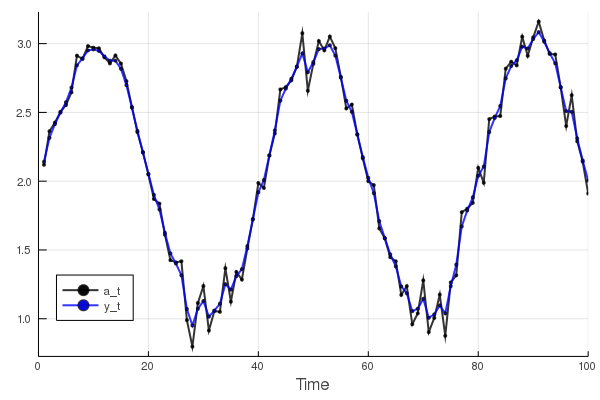

In [4]:
gr(fmt=:png);

# definir seed e gerar uma sequência a_t
Random.seed!(123)
n = 100
a_seq = sin.(range(0,  5 * pi, length = n)) .+ 2 + 0.1 * randn(n)

function plot_simulation(;γ=0.8, m=1, h=1., y_m=2.)
  d = γ * [1, -1]
  y_m = [y_m]

  testlq = LQFilter(d, h, y_m)
  y_hist, L, U, y = optimal_y(testlq, a_seq)
  y = y[end:-1:1]  # reverse y

  # plota os resultados da simulação
  time = 1:length(y)
  plt = plot(time, a_seq / h, lw=2, color=:black, alpha=0.8, marker = :circle,
             markersize = 2, label="a_t")
  plot!(plt, time, y, lw=2, color=:blue, marker = :circle,  markersize = 2, alpha=0.8,
        label="y_t")
  plot!(plt, xlabel="Time", grid=true, xlim=(0,maximum(time)), legend=:bottomleft)
end

plot_simulation()

Aqui está o que acontece quando mudamos $ \gamma $ para 5.0

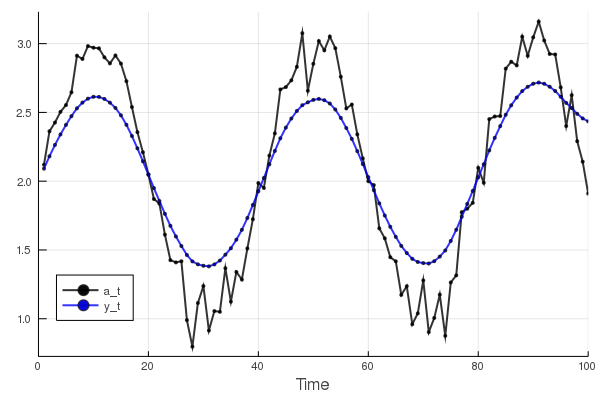

In [5]:
plot_simulation(γ=5.0)

E aqui está $ \gamma = 10 $

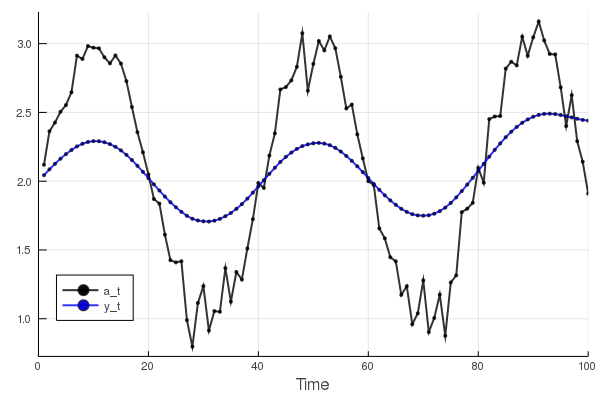

In [6]:
plot_simulation(γ=10.0)

## Exercícios

### Exercício 1

Considere resolver uma versão do problema descontado $ (\beta < 1) $
[(1)](#equation-oneone), como o seguinte.

Converta [(1)](#equation-oneone) para o problema não descontado [(22)](#equation-oneoneprime).

Seja a solução de [(22)](#equation-oneoneprime) na forma feedback seguir:

$$
(1 - \tilde \lambda_1 L)\, \cdots\, (1 - \tilde \lambda_m L) \tilde y_t =
\sum^m_{j=1} \tilde A_j \sum^\infty_{k=0} \tilde \lambda^k_j \tilde a_{t+k}
$$

ou


<a id='equation-estar'></a>
$$
\tilde y_t = \tilde f_1 \tilde y_{t-1} + \cdots + \tilde f_m \tilde y_{t-m} +
\sum^m_{j=1} \tilde A_j \sum^\infty_{k=0} \tilde \lambda^k_j \tilde a_{t+k} \tag{25}
$$

Aqui

- $ h + \tilde d (z^{-1}) \tilde d (z) = \tilde c (z^{-1}) \tilde c (z) $  
- $ \tilde c (z) = [(-1)^m \tilde z_0 \tilde z_1 \cdots \tilde z_m ]^{1/2} (1 - \tilde \lambda_1 z) \cdots (1 - \tilde \lambda_m z) $  


onde o $ \tilde z_j $ são os zeros de $ h +\tilde d (z^{-1})\, \tilde d(z) $.

Prove que [(25)](#equation-estar) implica que a solução para  $ y_t $ na forma de feedback é:

$$
y_t = f_1 y_{t-1} + \ldots + f_m y_{t-m} + \sum^m_{j=1} A_j
\sum^\infty_{k=0} \beta^k \lambda^k_j a_{t+k}
$$

onde $ f_j = \tilde f_j \beta^{-j/2}, A_j = \tilde A_j $, e $ \lambda_j = \tilde \lambda_j \beta^{-1/2} $.

### Exercício 2

Resolva o problema de controle ótimo, maximize:

$$
\sum^2_{t=0}\ \Bigl\{a_t y_t - {1 \over 2} [(1 - 2 L) y_t]^2\Bigr\}
$$

sujeito a $ y_{-1} $ dado, e $ \{ a_t\} $ uma sequência limitada conhecida.

Expresse a solução na “forma de feedback” [(20)](#equation-onefifteen), fornecendo valores numéricos para os coeficientes.

Verifique se as condições de contorno [(5)](#equation-onefive) são satisfeitas.

(Nota: esse problema difere do problema no texto de uma maneira importante: em vez de $ h > 0 $ em [(1)](#equation-oneone), $ h = 0 $. Isso tem uma influência importante na solução.)

### Exercício 3

Resolva o problema de controle ideal de tempo infinito para maximizar:

$$
\lim_{N \rightarrow \infty}
\sum^N_{t=0}\, -\, {1 \over 2} [(1 -2 L) y_t]^2,
$$

sujeito a dado $ y_{-1} $. Prove que a solução é:

$$
y_t = 2y_{t-1} = 2^{t+1} y_{-1} \qquad t > 0
$$

### Exercício 4

Resolva o problema de tempo infinito, para maximizar:

$$
\lim_{N \rightarrow \infty}\ \sum^N_{t=0}\ (.0000001)\, y^2_t - {1 \over 2}
[(1 - 2 L) y_t]^2
$$

subjeito a dado $ y_{-1} $. Prove que a solução $ y_t = 2y_{t-1} $ viola a condição [(12)](#equation-onesix), e então
não é o ideal.

Prove que a solução ideal é aproximadamente $ y_t = .5 y_{t-1} $.